# Optimization and Selection of Audio Classification Model

### Liam Kelly

In this notebook, the data which was processed in the previous notebook (EDA_of_audio_data.ipynb) will be used to optimize and evaluate three different classification models to determine the best model for speech recognition. The three models that will be considered will be a Logistic Regression model, a Random Forest model, and an XGBoost model. Each model will have its hyperparameters optimized using a grid search, then each model will be evaluated on the following metrics:
- Accuracy score
- Precision score
- Recall score
- Confusion matrix

The model which performs the best will be used in the baseline speech recognition app.

## Importing Data

First, the data will be imported from its csv file, then be quickly inspected.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Read the data from its csv file
df = pd.read_csv("csv_files/model_comp_df.csv")

# Print the shape and head of the dataframe:
print(df.shape)
df.head()

(30956, 15)


,id,word,data_len,sampling_rate,temporal_bandwidth,temporal_skewness,temporal_kurtosis,temporal_irregularity,spectral_centroid,spectral_bandwidth,spectral_skewness,spectral_kurtosis,spectral_flatness,spectral_irregularity,spectral_rolloff
0,00176480_nohash_0,down,16000.0,16000.0,0.672536,0.803511,1.451310,0.631618,5.796382,0.453010,0.235713,0.650019,1.668561,-4.528923,1659.836643
1,004ae714_nohash_0,down,16000.0,16000.0,0.719680,-0.883279,1.838430,0.894988,6.524944,0.471399,-1.642777,0.396626,1.617631,-2.587713,2133.526166
2,00b01445_nohash_0,down,16000.0,16000.0,0.715575,-0.304882,1.451752,0.662998,5.884406,0.463789,0.538033,0.551821,1.702899,-2.312052,1568.767314
3,00b01445_nohash_1,down,16000.0,16000.0,0.712285,0.301250,1.083588,0.724117,6.043622,0.464451,0.139646,0.580902,1.690714,-2.626828,1736.532500
4,00f0204f_nohash_0,down,16000.0,16000.0,0.772226,0.691076,0.903633,0.540520,5.657420,0.450404,0.588880,0.626604,1.653757,-2.431605,1567.566041


In [3]:
# Check for null values:
df.isnull().sum().sum()

0

The data can now be split into an independent variable (X) and dependent variable (y). The data can then be split into a training set, for optimizing its hyperparameters, and a testing set, to evaluate its performance.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(columns = ['id','word','sampling_rate', 'data_len']) # Select the independent variables
y = df['word'] # Select the dependent variable

# Split the data into a training and testing set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 9)

## Classification Models

### Logisitic Regression Model

The first model we will consider is the logistion regression model. The logistic regression model is very simple, and thus the results are easily explainable. It should be noted that Logisitc Regression assumes no multicollinearity between features, and in the previous notebook it was discovered that there is significant mutlicollinearity between features in our dataset. Thus the coefficient values produced from the model will not have any physical significance.

To optimize the hyperparameters of the model, a grid search will be used to evaluate the validation score of the model as the hyperparameters are iterated.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Initialize the range of C values:
C_val = np.power(10,np.arange(-3,4,dtype=float)) 

# Specify the estimators:
estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression(max_iter = 10000, solver = 'liblinear'))] 

# Initialize the logisitc regression pipeline
logreg_pipe = Pipeline(estimators) 

# Specify the parameters to iterate over in the grid search:
params = [{'model__C': C_val,
         'model__penalty' : ['l2']},
         {'model__C': C_val,
         'model__penalty' : ['l1']},
         {'model__C': C_val,
         'model__penalty' : ['l2'],
         'model__solver' : ['lbfgs']}]

# Initialize the grid search object:
grid_log = GridSearchCV(logreg_pipe, param_grid=params, cv = 5)

# Fit the training data:
fittedgrid_log = grid_log.fit(X_train, y_train)

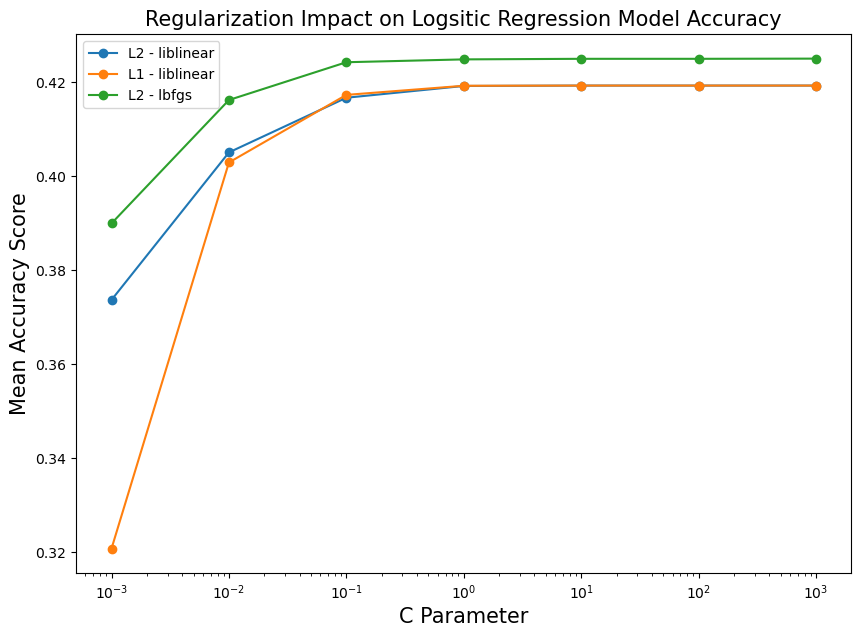

The best estimator is: Pipeline(steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=1000.0, max_iter=10000))])


In [6]:
# Plot the results from the grid search:
plt.figure(figsize=(10,7))
plt.plot(C_val,fittedgrid_log.cv_results_['mean_test_score'][:7], marker = 'o', label = 'L2 - liblinear')
plt.plot(C_val,fittedgrid_log.cv_results_['mean_test_score'][7:14], marker = 'o', label = 'L1 - liblinear')
plt.plot(C_val,fittedgrid_log.cv_results_['mean_test_score'][14:], marker = 'o', label = 'L2 - lbfgs')
plt.xscale('log')
plt.title('Regularization Impact on Logsitic Regression Model Accuracy', fontsize = 15)
plt.xlabel('C Parameter', fontsize = 15)
plt.ylabel('Mean Accuracy Score', fontsize = 15)
plt.legend()
plt.show()

# Print the optimal model:
print('The best estimator is: %s' % fittedgrid_log.best_estimator_)

In [7]:
# Determine the train and test accuracy scores for the optimized model:
scaler = StandardScaler().fit(X_train)
log_model = LogisticRegression(C = 10, max_iter=10000)
log_model.fit(scaler.transform(X_train),y_train)
print('The model score on the train data is %.2f' % log_model.score(scaler.transform(X_train), y_train))
print('The model score on the test data is %.2f' %  log_model.score(scaler.transform(X_test), y_test))

The model score on the train data is 0.43
The model score on the test data is 0.42


The Logistic regression model performs fairly, it demonstrates a huge imporvement from the baseline accuracy of guessing the same word everytime (12.5%), yet falls short of the high accuracy required for this project.

To further evaluate the model performance, we can look at the precision and recall. The precision will let us know, for a predicted label A, what is the percentage of those predicted values that are actually A.

This metric can be caluclated using the sklearn precision_score function. We can visualize the precision for each label, as well as return the precision of all labels combined:

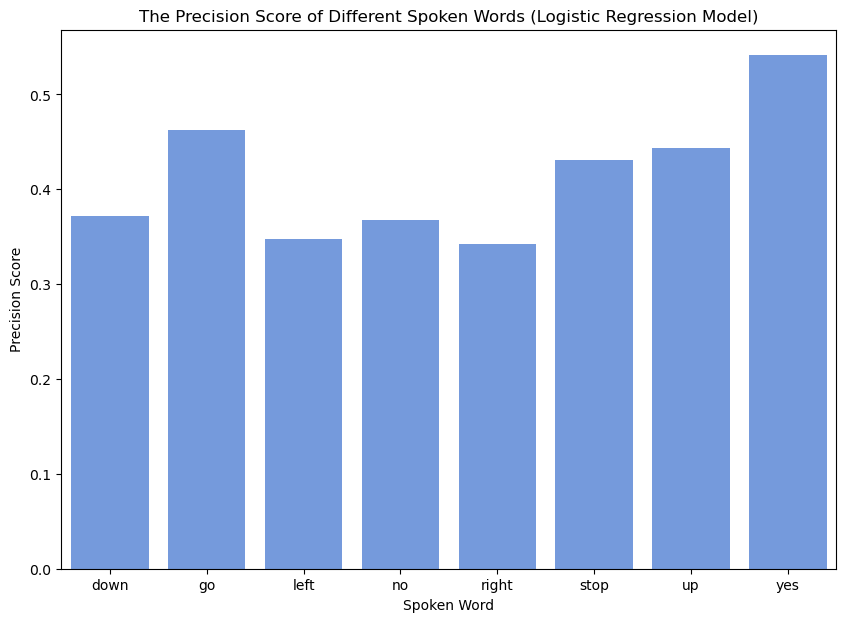

The precision of all labels combined is: 0.422


In [8]:
# Calculate and visualize the precision.
from sklearn.metrics import precision_score

# Calculate the predicted values from the test data:
y_pred = log_model.predict(scaler.transform(X_test))

# Calculate the precision score for each label:
pre_score =  precision_score(y_test, y_pred, average = None)

# Visualize the precision score for each label:
plt.figure(figsize = (10,7))
sns.barplot(x = df.word.unique(), y = pre_score, color = 'cornflowerblue')
plt.xlabel('Spoken Word')
plt.ylabel('Precision Score')
plt.title('The Precision Score of Different Spoken Words (Logistic Regression Model)')
plt.show()

# Print the overall precision score:
print('The precision of all labels combined is: %.3f' % precision_score(y_test, y_pred, average = 'micro'))

From the above result, we can say that on average, when the model predicts an audio file has a label X, the model is correct 39.7 % of the time. The model is most likely to be correct when it predicts a value of 'yes' or 'go', and is least likely to be correct when it predicts 'right'.

We can also look at the recall, which measure for a given true label, how many of the elements containing this label did the model correctly identify. As above, the recall will be calculated using the sklearn recall_score function and will be visualized for each label.

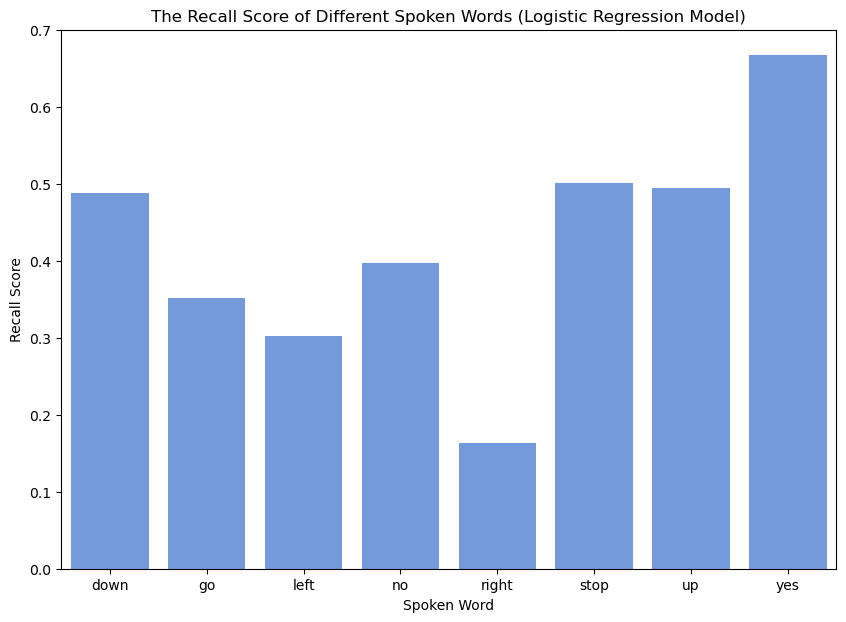

The recall of all labels combined is: 0.422


In [9]:
# Calculate and visualize the recall.
from sklearn.metrics import recall_score

# Calculate the recall score for each label:
rec_score =  recall_score(y_test, y_pred, average = None)

# Visualize the recall score for each label:
plt.figure(figsize = (10,7))
sns.barplot(x = df.word.unique(), y = rec_score, color = 'cornflowerblue')
plt.xlabel('Spoken Word')
plt.ylabel('Recall Score')
plt.title('The Recall Score of Different Spoken Words (Logistic Regression Model)')
plt.show()

# Print the overall recall score:
print('The recall of all labels combined is: %.3f' % recall_score(y_test, y_pred, average = 'micro'))

From above, we can see that the model is best at correctly identifying a high proportion of the 'yes' labels, and is the worst at identifying a high proportion of the 'right' labels.

Finally, to get a better sense of which words the model is good and bad at predicting, a confusion matrix can be plotted to visualize the true and predicted labels for each audio sample:

C:\Users\liamg\anaconda3\envs\capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


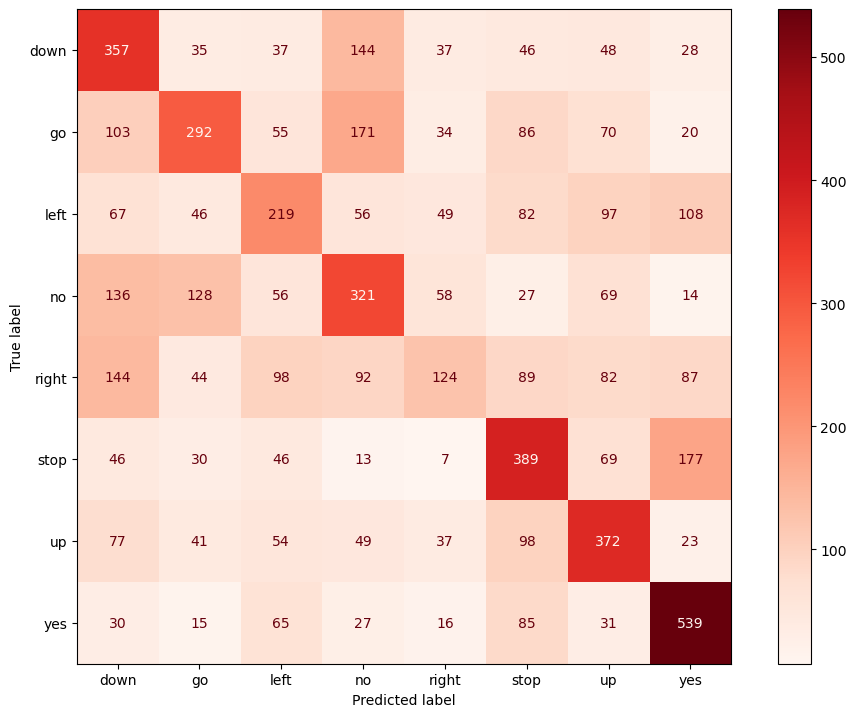

In [10]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

fig, axes = plt.subplots(1, 1, figsize=(12, 8.5)) # Create figure and axes objects to create the figure 
plot_confusion_matrix(log_model, scaler.transform(X_test), y_test, cmap = 'Reds', ax = axes) # Plot the confusion matrix on the previosuly created axes object.
plt.show() # Show

From the elements on the diagonal, the correctly classified labels, we can see that the model performs well at predicting 'yes', 'stop', and 'down'. However, the model performs poorly with the word 'right' and actually classifies audio samples with this label as 'down' more often than it classifies the audio sample with the correct 'right' label. Thus while the model is generally good at determining the correct labels for some words, for others its not much better than random chance.

Finally, the model can be saved as a .sav file to be used in subsequent notebooks.

In [11]:
import pickle

# Save the classification model and the scaler:
pickle.dump(log_model, open('models/log_model.sav', 'wb'))
pickle.dump(scaler, open('models/scaler.sav', 'wb'))

### Random Forrest

Due to the strong presence of multicolinearity in the dataset, it makes sense to use models which are not affected by it. Two powerful models which don't operate under the assumption of collinearty are decision tree based models: Random Forest and XGBoost. As a further bonus, neither model requires scaling of the X data.

We will start by evaluating the Random Forest model. Again, a grid search will be performed to optimize the hyperparameters of the model.

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the estimators:
estimators = [('model', RandomForestClassifier())]

# Define the Random Forest model
rf_model = RandomForestClassifier(n_jobs=-1, random_state = 9) # Specifiy n_jobs = -1 to use all available processors.

# Specify the hyperparameters to iterate over:
params = {'n_estimators': np.arange(1, 82, 20), 
              'max_depth': np.arange(1, 16, 2)}

grid_rf = GridSearchCV(rf_model, param_grid=params, cv = 5)
fittedgrid_rf = grid_rf.fit(X_train, y_train)

In [13]:
# Create a DataFrame to store the results from the Random Forest Model:
results_rf = pd.DataFrame({
                        "n_estimators": grid_rf.cv_results_['param_n_estimators'],
                        'max_depth' : grid_rf.cv_results_['param_max_depth'].astype(str),
                        'mean_score': grid_rf.cv_results_['mean_test_score']
                            })

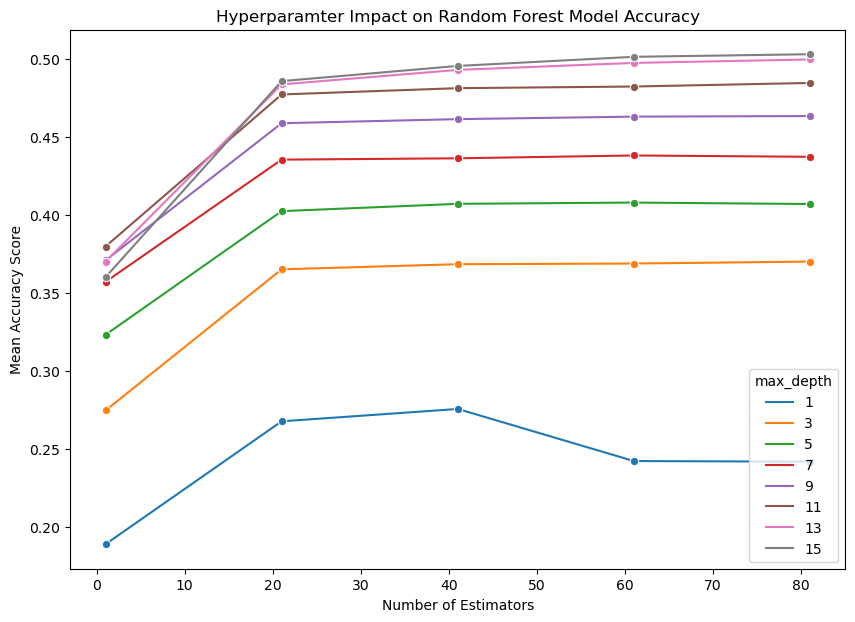

The best estimator is: RandomForestClassifier(max_depth=15, n_estimators=81, n_jobs=-1, random_state=9)


In [14]:
# Plot the results from the GridSearch:
plt.figure(figsize=(10,7))
sns.lineplot(x="n_estimators", y="mean_score", hue="max_depth", marker = 'o', data=results_rf)
plt.title('Hyperparamter Impact on Random Forest Model Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy Score')
plt.show()

print('The best estimator is: %s' % fittedgrid_rf.best_estimator_)

In [15]:
# Determine the train and test accuracy scores for the optimized model:
rf_model = RandomForestClassifier(max_depth=15, n_estimators=81, n_jobs=-1, random_state=9)
rf_model.fit(X_train,y_train)
print('The model score on the train data is %.2f' % rf_model.score(X_train, y_train))
print('The model score on the test data is %.2f' %  rf_model.score(X_test, y_test))

The model score on the train data is 0.96
The model score on the test data is 0.51


We find that the Random Forest model has slightly better performance than the Logistic Regression, however the model is certainly overfitting on the training data.

To further evaluate the model performance, we can again look at the precision and recall:

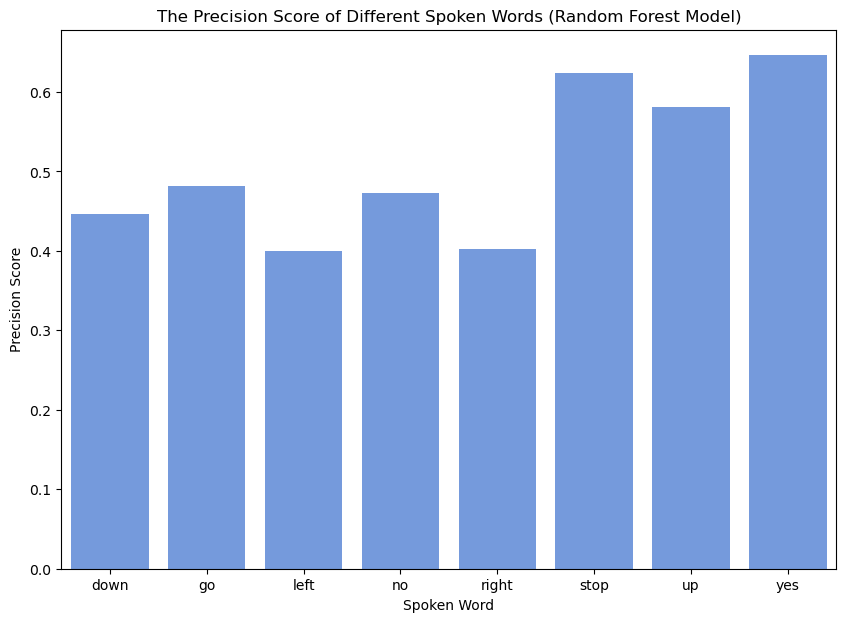

The precision of all labels combined is: 0.513


In [16]:
# Calculate and visualize the precision.
from sklearn.metrics import precision_score

# Calculate the predicted values from the test data:
y_pred = rf_model.predict(X_test)

# Calculate the precision score for each label:
pre_score =  precision_score(y_test, y_pred, average = None)

# Visualize the precision score for each label:
plt.figure(figsize = (10,7))
sns.barplot(x = df.word.unique(), y = pre_score, color = 'cornflowerblue')
plt.xlabel('Spoken Word')
plt.ylabel('Precision Score')
plt.title('The Precision Score of Different Spoken Words (Random Forest Model)')
plt.show()

# Print the overall precision score:
print('The precision of all labels combined is: %.3f' % precision_score(y_test, y_pred, average = 'micro'))

Again, the model performs best on 'yes' and worse on 'right', but precision scores improve across the board.

Next, let's look at recall.

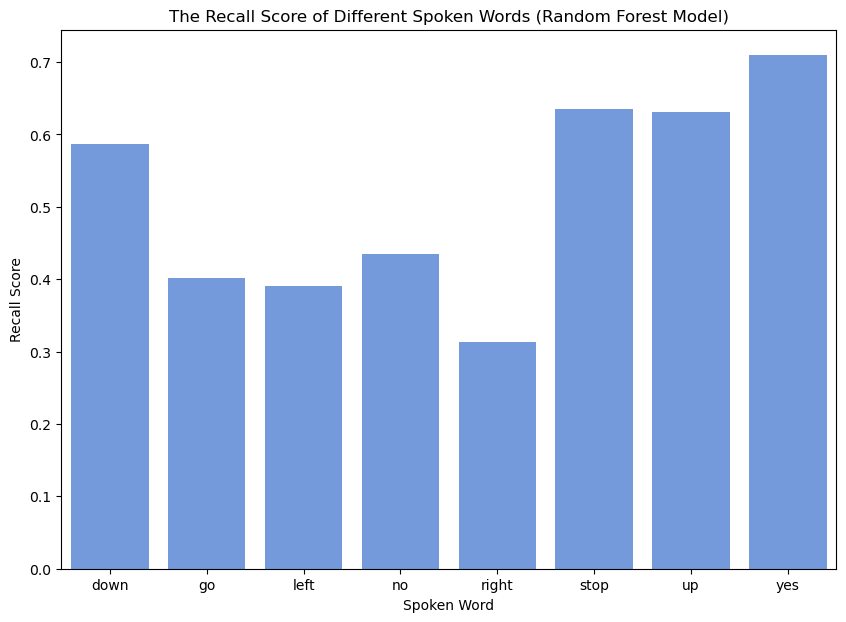

The recall of all labels combined is: 0.513


In [17]:
# Calculate and visualize the recall.
from sklearn.metrics import recall_score

# Calculate the recall score for each label:
rec_score =  recall_score(y_test, y_pred, average = None)

# Visualize the recall score for each label:
plt.figure(figsize = (10,7))
sns.barplot(x = df.word.unique(), y = rec_score, color = 'cornflowerblue')
plt.xlabel('Spoken Word')
plt.ylabel('Recall Score')
plt.title('The Recall Score of Different Spoken Words (Random Forest Model)')
plt.show()

# Print the overall recall score:
print('The recall of all labels combined is: %.3f' % recall_score(y_test, y_pred, average = 'micro'))

Again the model is best at correctly identifying a high proportion of the 'yes' labels, and is the worst at identifying a high proportion of the 'right' labels, but is overall much better than the Logistic Regression model.

Finally, let's create the confusion matrix:

C:\Users\liamg\anaconda3\envs\capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


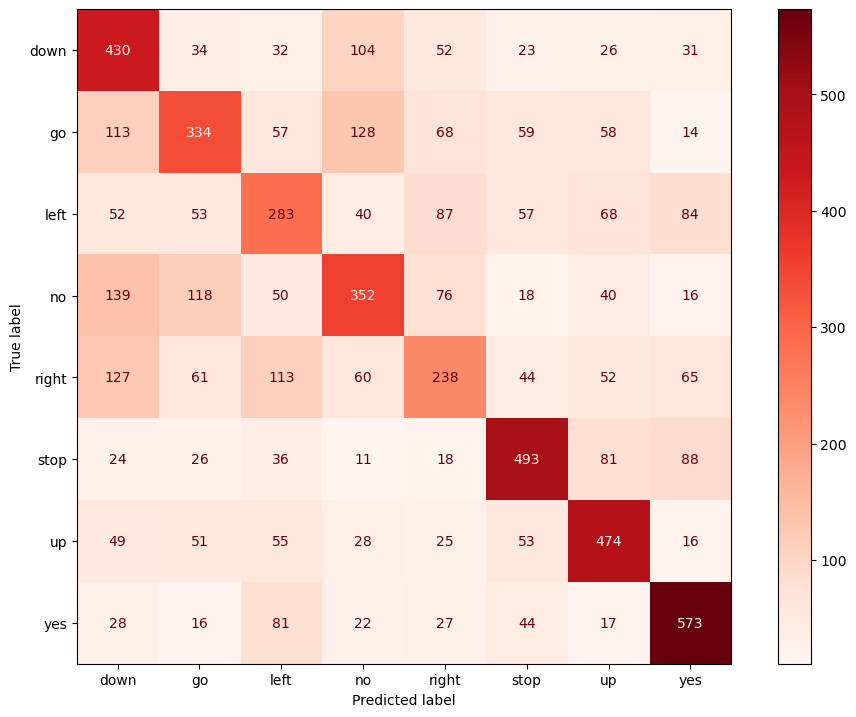

In [18]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

fig, axes = plt.subplots(1, 1, figsize=(12, 8.5)) # Create figure and axes objects to create the figure 
plot_confusion_matrix(rf_model, X_test, y_test, cmap = 'Reds', ax = axes) # Plot the confusion matrix on the previosuly created axes object.
plt.show() # Show

In comparison to the logistic regression model, the XGBoost model does a much better job at correctly classifying labels. While there is some improvement in classifying labels that the logistic regression model already did well with, the true improvement comes with the words that the logistic regression model struggled with. All labels are classified correctly than there are classified for any other label (i.e., the diagonal elements are always the largest values in their respectivel rows and columns). However, for many words, the correctly label is selected less than half of the time.

Finally, the model can be saved as a .sav file to be used in subsequent notebooks.

In [19]:
import pickle

# Save the classification model:
pickle.dump(rf_model, open('models/rf_model.sav', 'wb'))

### XGBoost

The last model we will consider is XGBoost. Like Random Forest, XGBoost is built on many Decision Tree models but instead of using bagging to combine models, XGBoost uses boosting to learn from previous errors.

A grid search will be employed to determine the optimal hyperparameters for this model.

**WARNING:** The following cell takes long to run.

In [20]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Since XGBoost expects integer class labels, a label encoder must be used to convert the string class labels to alias integer values.
le = LabelEncoder().fit(y_train)

# Specify the estimators for the grid searchL
estimators = [('model', XGBClassifier())]

# initialize the model:
xgb_model = XGBClassifier(n_jobs=-1, random_state = 9)

# Specify the values to iterate over for the hyperparameters:
params = {'n_estimators': np.arange(1, 140, 20), 
              'max_depth': np.arange(1, 8, 2)}

grid_xgb = GridSearchCV(xgb_model, param_grid=params, cv = 5) # Create the GridSearchCV object
fittedgrid_xgb = grid_xgb.fit(X_train, le.transform(y_train)) # Fit the model to the train data.

C:\Users\liamg\anaconda3\envs\capstone\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [21]:
# Create a DataFrame to store the results from the grid search:
results_xgb = pd.DataFrame({ 
                            "n_estimators": grid_xgb.cv_results_['param_n_estimators'],
                            'max_depth' : grid_xgb.cv_results_['param_max_depth'].astype(str),
                            'mean_score': grid_xgb.cv_results_['mean_test_score']
                            })

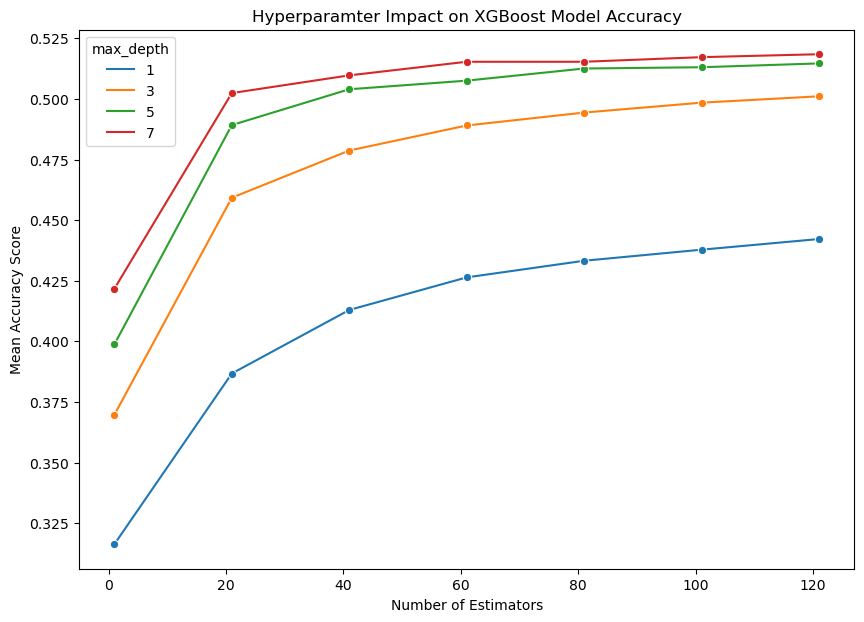

The best estimator is: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=121, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=9, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [22]:
# Plot the results from the gridsearch:
plt.figure(figsize=(10,7))
sns.lineplot(x="n_estimators", y="mean_score", hue="max_depth", marker = 'o', data=results_xgb)
plt.title('Hyperparamter Impact on XGBoost Model Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy Score')
plt.show()

# Print the model with the highest score on the validation set:
print('The best estimator is: %s' % fittedgrid_xgb.best_estimator_)

In [23]:
# Determine the train and test scores for the optimized model:
xgb_model = XGBClassifier(max_depth = 7, n_estimators = 121)
xgb_model.fit(X_train,le.transform(y_train))
print('The model score on the train data is %.2f' % xgb_model.score(X_train, le.transform(y_train)))
print('The model score on the test data is %.2f' %  xgb_model.score(X_test, le.transform(y_test)))

The model score on the train data is 0.96
The model score on the test data is 0.53


XGBoost scores an even higher score on the test data than the Random Forest model, and is showing less overfitting from its reduced performance on the training data.

Let's again evaluate the precision:

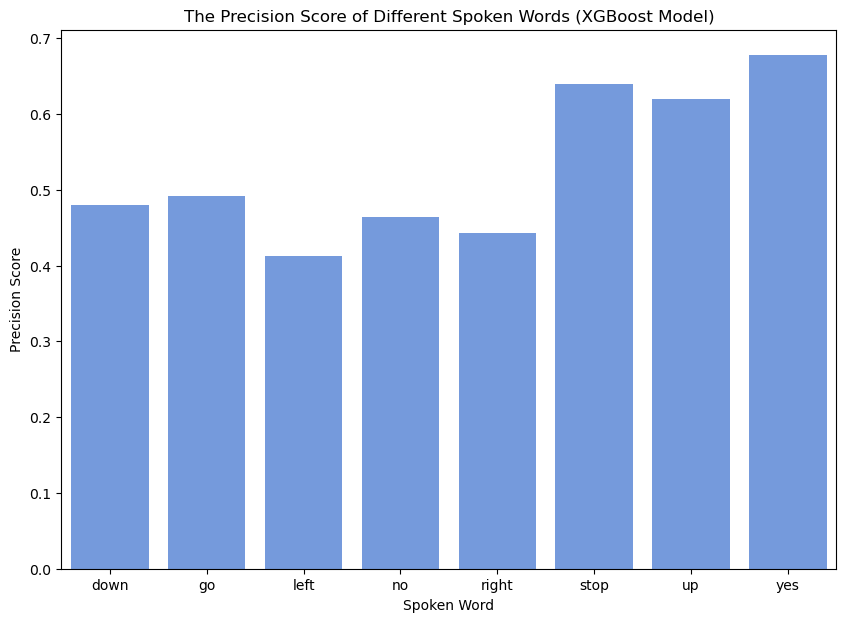

The precision of all labels combined is: 0.533


In [24]:
# Calculate and visualize the precision.
from sklearn.metrics import precision_score

# Calculate the predicted values from the test data:
y_pred = xgb_model.predict(X_test)

# Calculate the precision score for each label:
pre_score =  precision_score(y_test, le.inverse_transform(y_pred), average = None)

# Visualize the precision score for each label:
plt.figure(figsize = (10,7))
sns.barplot(x = df.word.unique(), y = pre_score, color = 'cornflowerblue')
plt.xlabel('Spoken Word')
plt.ylabel('Precision Score')
plt.title('The Precision Score of Different Spoken Words (XGBoost Model)')
plt.show()

# Print the overall precision score:
print('The precision of all labels combined is: %.3f' % precision_score(y_test, le.inverse_transform(y_pred), average = 'micro'))

The precision scores appear to be much more balanced than previous models, indicated that the XGBoost model is not as biased to particular labels. 

Let's also look at recall:

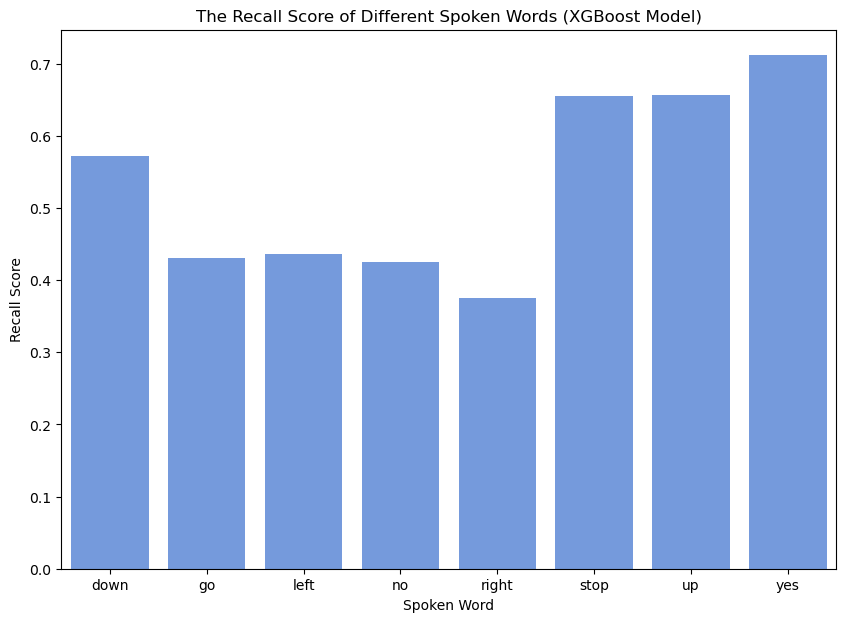

The recall of all labels combined is: 0.533


In [25]:
# Calculate and visualize the recall.
from sklearn.metrics import recall_score

# Calculate the recall score for each label:
rec_score =  recall_score(y_test, le.inverse_transform(y_pred), average = None)

# Visualize the recall score for each label:
plt.figure(figsize = (10,7))
sns.barplot(x = df.word.unique(), y = rec_score, color = 'cornflowerblue')
plt.xlabel('Spoken Word')
plt.ylabel('Recall Score')
plt.title('The Recall Score of Different Spoken Words (XGBoost Model)')
plt.show()

# Print the overall recall score:
print('The recall of all labels combined is: %.3f' % recall_score(y_test, le.inverse_transform(y_pred), average = 'micro'))

Similar to the precision results, the recall scores are much more balanced, indicating lessened bias when compared to the previous models.

Finally, the strengths and weaknesses of the model can be visualized using a confusion matrix:

C:\Users\liamg\anaconda3\envs\capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


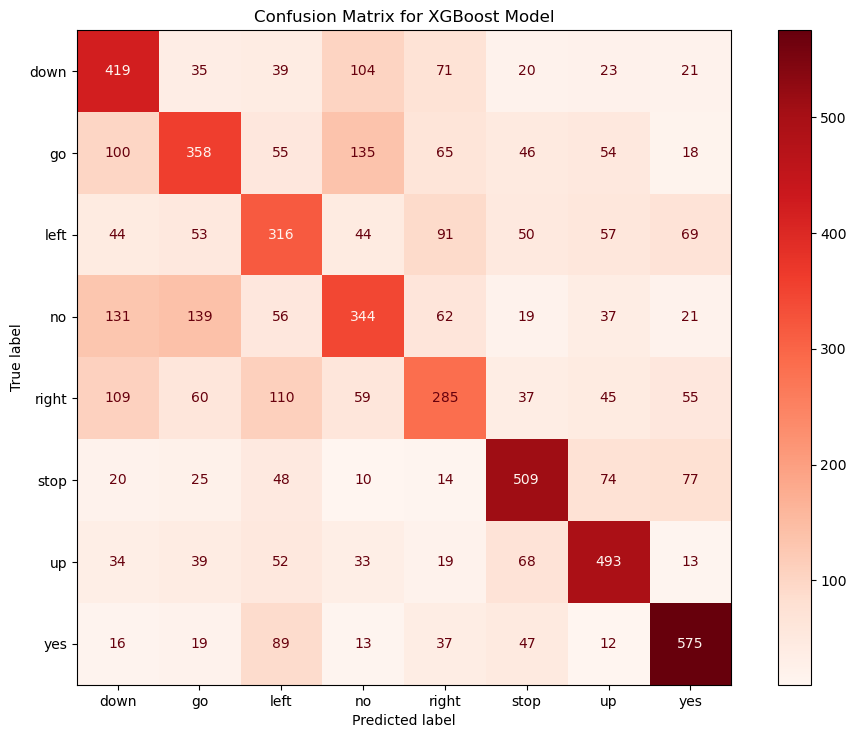

In [28]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

fig, axes = plt.subplots(1, 1, figsize=(12, 8.5)) # Create figure and axes objects to create the figure

plot_confusion_matrix(xgb_model, X_test, le.transform(y_test), cmap = 'Reds', ax = axes) # Plot the confusion matrix on the previosuly created axes object.
plt.title('Confusion Matrix for XGBoost Model')
# Convert the axis tick labels from label encoded values to the actual audio labels:
plt.yticks(ticks = range(8), labels = le.inverse_transform(range(8)))
plt.xticks(ticks = range(8), labels = le.inverse_transform(range(8)))
plt.show()

The confusion matrix from the XGBoost model again exhibits optimal performance. There is a strong confinement of data to the diagonal, with very few off-diagonal elements having significant values.

We can save this model and the label encoder for use in future notebooks:

In [27]:
import pickle

# Save the classification model:
pickle.dump(xgb_model, open('models/xgb_model.sav', 'wb'))
pickle.dump(le, open('models/label_encoder.sav', 'wb'))

Since XGBoost demonstrated the best performance, it will be used in the baseline speech recognition app.